<a href="https://colab.research.google.com/github/lowem1/lowem1-experiments-n-notes/blob/master/research/mockdocs/summaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
import polars as pl
import random
import json
from typing import List, Tuple, Dict, Optional

import names
import phone_gen
import random
from random_address import real_random_address
import polars as pl
import os
import configparser
from io import BytesIO
from pdf2image import convert_from_bytes

logging.basicConfig(level=logging.INFO)

In [ ]:
from fpdf import FPDF

In [ ]:

config = configparser.ConfigParser()
config.read("config/config.ini")
conf = config["dev.sources"]

# lift black formatting for sanity
# fmt: off

NOTES: str = (
    conf["NOTES"] if "NOTES" in conf else None
)

SERVICES: str = (
    conf["SERVICES"] if "SERVICES" in conf else None
)

ICD9_DIAGNOSIS: str = (
    conf["ICD9_DIAGNOSIS"] if "ICD9_DIAGNOSIS" in conf else None
)

ICD9_DIAGNOSIS_DESC: str = (
    conf["ICD9_DIAGNOSIS_DESC"] if "ICD9_DIAGNOSIS_DESC" in conf else None
)

ADMISSIONS: str = (
    conf["ADMISSIONS"] if "ADMISSIONS" in conf else None
)

ICD9_PROCEDURES: str = (
    conf["ICD9_PROCEDURES"] if "ICD9_PROCEDURES" in conf else None
)

ICD9_PROCEDURES_DESC: str = (
    conf["ICD9_PROCEDURES_DESC"] if "ICD9_PROCEDURES_DESC" in conf else None
)

STAGING_DIR: str = (
    conf["STAGING_DIR"] if "STAGING_DIR" in conf else None
)

PATIENTS: str = (
    conf["PATIENTS"] if "PATIENTS" in conf else None
)

CPT_EVENTS: str = (
    conf["CPT_EVENTS"] if "CPT_EVENTS" in conf else None
)

MOCK_DOCS: str = (
    conf["MOCK_DOCS"] if "MOCK_DOCS" in conf else None
)

MOCK_SUMMARIES: str = (
    conf["MOCK_SUMMARIES"] if "MOCK_SUMMARIES" in conf else None
)

MOCK_CMS_DOCS: str = (
    conf["MOCK_CMS_DOCS"] if "MOCK_CMS_DOCS" in conf else None
)

# fmt: on


In [ ]:
def get_patient_summaries(
    events_uri: str, admissions_uri: str, output_summary_uri: str, limit: int = None
) -> None:
    # ingest and validate schema
    admissions_df = pl.read_csv(admissions_uri)
    admissions_tbl = (
        admissions_df.select(
            [
                "HADM_ID",
                "ADMITTIME",
                "DISCHTIME",
                "ADMISSION_TYPE",
                "ADMISSION_LOCATION",
                "DISCHARGE_LOCATION",
                "INSURANCE",
                pl.col("DIAGNOSIS").apply(lambda _: _.lower().strip()),
                "HOSPITAL_EXPIRE_FLAG",
            ]
        )
        .filter(pl.col("HOSPITAL_EXPIRE_FLAG") == 0)
        .drop("HOSPITAL_EXPIRE_FLAG")
        .sort("HADM_ID", descending=True)
    )
    # ingest and validate schema
    cptevents_df = pl.read_csv(events_uri, ignore_errors=True)
    cptevents_tbl = cptevents_df.select(
        [
            "HADM_ID",
            "CHARTDATE",
            "CPT_CD",
            pl.col("SECTIONHEADER").apply(lambda _: _.lower().strip()),
            pl.col("DESCRIPTION").apply(lambda _: _.lower().strip()),
            "TICKET_ID_SEQ",
        ]
    ).sort(by=["HADM_ID", "TICKET_ID_SEQ"], descending=False)

    mock_invoice_tbl = (
        admissions_tbl.join(cptevents_tbl, on="HADM_ID", how="left")
        .with_columns(
            pl.col("DESCRIPTION")
            .fill_null(pl.col("SECTIONHEADER"))
            .apply(lambda _: _.strip())
        )
        .sort(by=["HADM_ID", "TICKET_ID_SEQ"], descending=False)
    )

    patients = mock_invoice_tbl.select("HADM_ID").unique()
    mock_summaries = []
    # @TODO: increase limit to generate mocks
    for patient in patients.to_numpy()[:limit]:
        logging.info(f"Processing patient summary with HADM: {patient}")
        df = mock_invoice_tbl.filter(pl.col("HADM_ID") == patient)
        summary = generate_mock_rollups(df)
        logging.info(f"Processing patient rollup with HADM: {patient}")
        mock_summaries.append(summary)

    mock_summary_tbl = pl.DataFrame(mock_summaries)
    mock_summary_tbl.write_json(
        file=MOCK_SUMMARIES, row_oriented=True, pretty=True
    )

In [ ]:
df = pl.scan_csv(NOTES)

In [ ]:
df.select("CATEGORY").collect().unique()

CATEGORY
str
"""Consult"""
"""Echo"""
"""Discharge summ…"
"""General"""
"""Physician """
"""Social Work"""
"""Respiratory """
"""Case Managemen…"
"""Nursing"""


In [ ]:
sample_notes = (
    df.filter(
        pl.col("CATEGORY") == "General"
    ).head(10).select([
    "SUBJECT_ID", "HADM_ID", "CATEGORY", "TEXT"
    ])
).collect()

In [ ]:
sample_notes.to_pandas()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,31608,152365,General,Clinician: Resident\n Family meeting held w...
1,16605,109285,General,"Clinician: Nurse\n Pt w/ prostate CA, end-s..."
2,31608,152365,General,TITLE: Nutrition Consult & F/U\n Patient\n...
3,27370,101266,General,Attending MICU Note\n Chief Complaint: abd ...
4,29983,135689,General,TITLE: Nutrition Consult\n Consult received...
5,29551,114721,General,TITLE:\n Physical [**Hospital 859**]\n Rehab...
6,820,193603,General,TITLE:\n Physical Therapy / Rehab Services D...
7,28067,169880,General,Clinician: Attending\n I supervised the res...
8,28067,169880,General,Clinician: Attending\n Patient has had poor...
9,711,158767,General,"85yo w/ ho CHF, CAD, PVD, AF admitted from [*..."


In [ ]:
for row in sample_notes.rows(named=True):
    control_num = row["HADM_ID"]
    # print(control_num)
    pdf = MimicNote()
    pdf.body(admit_id = "TEST", name = "TEST", phone = "TEST", addr = "TEST", data=row["TEXT"])
    stream = BytesIO(pdf.output(dest="S"))
    stream.seek(0)
    images = convert_from_bytes(stream.read(), 200)
    for i, image in enumerate(images):
        filename = f"/tmp/{control_num}-{i+1}.png"
        logging.info(
            f"Writing patient invoice:  {dict(control_num=control_num, filename=filename)} "
        )
        image.save(filename)

/tmp/ipykernel_93440/12995560.py:58: DeprecationWarning: The parameter "ln" is deprecated. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 8, "Mock MIMIC Patient Note", 0, 1, "C")
/tmp/ipykernel_93440/12995560.py:76: DeprecationWarning: The parameter "ln" is deprecated. Instead of ln=2 use new_x=XPos.LEFT, new_y=YPos.NEXT.
  self.cell(w=40, h=ch, txt="Patient Information", ln=2)
/tmp/ipykernel_93440/12995560.py:78: DeprecationWarning: The parameter "ln" is deprecated. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(w=40, h=ch, txt=f"Name: {name}", ln=1)
/tmp/ipykernel_93440/12995560.py:79: DeprecationWarning: The parameter "ln" is deprecated. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(w=40, h=ch, txt=f"Contact: {phone}", ln=1)
/tmp/ipykernel_93440/12995560.py:80: DeprecationWarning: The parameter "ln" is deprecated. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(w=40, h=ch, txt=f"Hospital ID: {

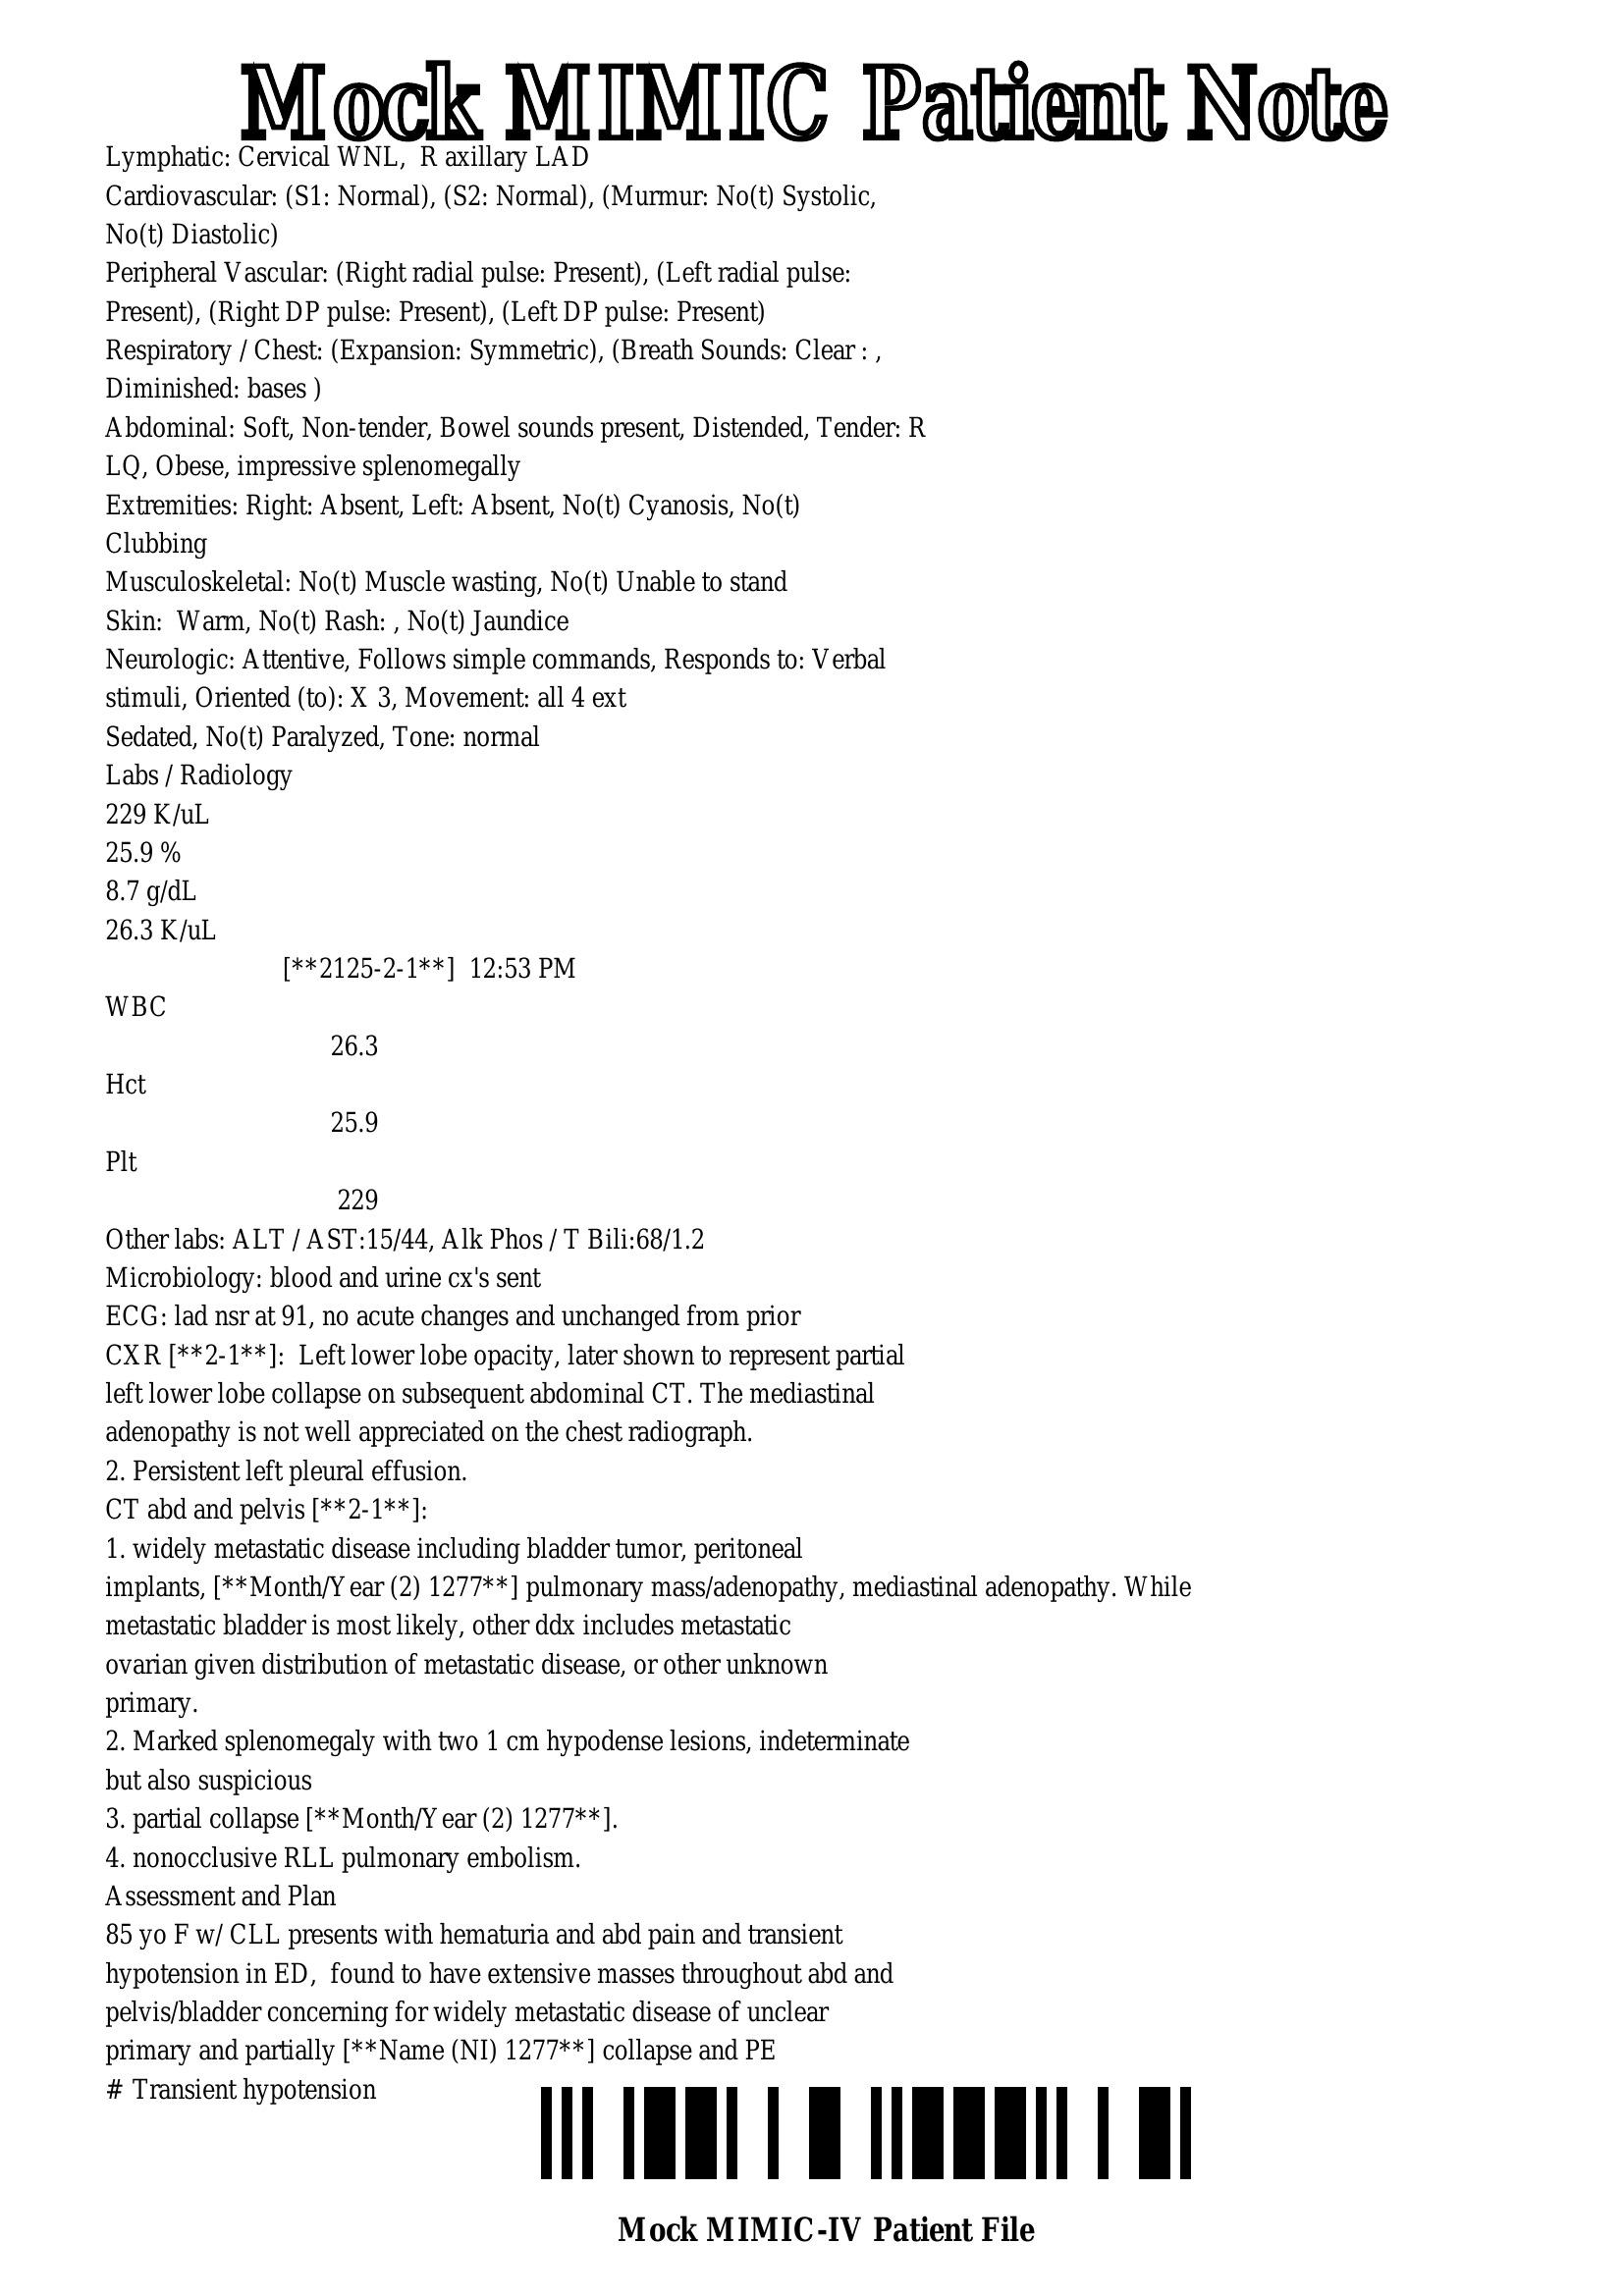

In [ ]:
import PIL
img = PIL.Image.open("/tmp/101266-4.png")
img.show()

In [ ]:
def with_mock_address() -> str:
    return ", ".join(
        [
            f"{value}"
            for key, value in real_random_address().items()
            if key != "coordinates" and len(value)
        ]
    )


def with_mock_phone_num() -> str:
    num = phone_gen.PhoneNumber("US").get_number(full=False)
    return "-".join([num[:3], num[3:6], num[6:]])


def with_moc_fullname(gender: str) -> str:
    _ = {"M": "male", "F": "female"}
    gender = _[gender] if gender in _.keys() else None
    return names.get_full_name(gender=gender)


def generate_mock_rollups(dataframe: pl.DataFrame):
    gender = "M"
    name = with_moc_fullname(gender)
    phone = with_mock_phone_num()
    addr = with_mock_address()
    _df = (
        dataframe.select(
            [
                "HADM_ID",
                "CHARTDATE",
                "ADMITTIME",
                "CPT_CD",
                "SECTIONHEADER",
                "DESCRIPTION",
                "DIAGNOSIS",
            ]
        )
        .with_columns(pl.col("DESCRIPTION").fill_null(pl.col("SECTIONHEADER")))
        .with_columns(pl.col("CHARTDATE").fill_null(pl.col("ADMITTIME")))
        .drop(["SECTIONHEADER", "ADMITTIME"])
        .to_pandas()
    )
    admit_id = _df["HADM_ID"].head(1)[0]
    _df = _df.drop("HADM_ID", axis=1)
    _df["PRICE"] = [round(random.uniform(1, 100), 2) for i in range(len(_df))]
    _df = _df.applymap(str)
    cols = [list(_df)]
    rows = _df.values.tolist()
    data = cols + rows
    return dict(name=name, phone=phone, addr=addr, admit_id=admit_id, data=data)


In [ ]:
class MimicClaim(FPDF):
    def __init__(self) -> None:
        super().__init__()
        self.ch = 8
        return

    def header(self) -> None:
        self.set_font("Times", "B", 36)  # init
        with self.local_context(text_mode="STROKE", line_width=2):
            self.cell(0, 8, "Mock Summary of Patient Visit", 0, 1, "C")
        return

    def footer(self) -> None:
        self.set_y(-15)
        self.set_font("Times", "", 12)
        self.interleaved2of5("12337", x=70, y=270, w=4, h=12)
        self.set_font("Times", "B", size=12)
        self.text(x=80, y=290, txt="Mock MIMIC-IV CMS-1500 Datafile")

    def body(
        self, admit_id: str, name: str, phone: str, addr: str, data: List[List["str"]]
    ) -> None:
        ch = self.ch
        self.add_page()
        self.image("config/mimic.png", 10, 20, 50, 0, "")
        self.set_font("Times", "B", 16)
        self.ln(30)
        self.cell(w=40, h=ch, txt="Patient Information", ln=2)
        self.set_font("Times", "", 10)
        self.cell(w=40, h=ch, txt=f"Name: {name}", ln=1)
        self.cell(w=40, h=ch, txt=f"Contact: {phone}", ln=1)
        self.cell(w=40, h=ch, txt=f"Hospital ID: {admit_id}", ln=1)
        self.cell(w=40, h=ch, txt="Facility No: MIMIC-III", ln=1)
        self.cell(w=40, h=ch, txt=f"Address: {addr}", ln=1)
        # self.cell(w=40, h=ch, txt="Admit ID: {admit_id}", ln=1)
        self.cell(w=40, h=ch, txt="Admit Date: 01/01/2023", ln=1)
        self.cell(w=40, h=ch, txt="Discharge Date: 01/01/2023", ln=1)
        # self.cell(w=40, h=ch*2, txt="Relevant Diagnosis Codes ICD9", ln=1)
        self.ln(ch)
        # @TODO: crreate different resolution variants
        with self.table(align="CENTER", borders_layout="MINIMAL") as table:
            self.set_font("Times", size=8)
            for data_row in data:
                row = table.row()
                for datum in data_row:
                    row.cell(datum)


class MimicNote(FPDF):
    def __init__(self) -> None:
        super().__init__()
        self.ch = 8
        return

    def header(self) -> None:
        self.set_font("Times", "B", 36)  # init
        with self.local_context(text_mode="STROKE", line_width=2):
            self.cell(0, 8, "Mock MIMIC Patient Note", 0, 1, "C")
        return

    def footer(self) -> None:
        self.set_y(-15)
        self.set_font("Times", "", 12)
        self.interleaved2of5("12337", x=70, y=270, w=4, h=12)
        self.set_font("Times", "B", size=12)
        self.text(x=80, y=290, txt="Mock MIMIC-IV Patient File")

    def body(
        self, admit_id: str, name: str, phone: str, addr: str, data: List[List["str"]]
    ) -> None:
        ch = self.ch
        self.add_page()
        self.image("config/mimic.png", 10, 20, 50, 0, "")
        self.set_font("Times", "B", 16)
        self.ln(30)
        self.cell(w=40, h=ch, txt="Patient Information", ln=2)
        self.set_font("Times", "", 10)
        self.cell(w=40, h=ch, txt=f"Name: {name}", ln=1)
        self.cell(w=40, h=ch, txt=f"Contact: {phone}", ln=1)
        self.cell(w=40, h=ch, txt=f"Hospital ID: {admit_id}", ln=1)
        self.cell(w=40, h=ch, txt="Facility No: MIMIC-III", ln=1)
        self.cell(w=40, h=ch, txt=f"Address: {addr}", ln=1)
        # self.cell(w=40, h=ch, txt="Admit ID: {admit_id}", ln=1)
        self.cell(w=40, h=ch, txt="Admit Date: 01/01/2023", ln=1)
        self.cell(w=40, h=ch, txt="Discharge Date: 01/01/2023", ln=1)
        txt = data
        # Times 12
        self.set_font('Times', '', 10)
        # Output justified text
        self.cell(w=40, h=ch,txt="[BEGIN MIMIC TEXT]" )
        self.multi_cell(0, 5, txt)
        self.cell(w=40, h=ch,txt="[END MIMIC TEXT]" )

        # Line break
        self.ln()



In [ ]:
def generate_claim_moc(input_filepath: str, output_filepath: str) -> None:
    mock_invoice_tbl = pl.read_json(input_filepath)

    for row in mock_invoice_tbl.rows(named=True):
        control_num = row["admit_id"]
        # print(control_num)
        pdf = MimicClaim()
        pdf.body(**row)
        stream = BytesIO(pdf.output(dest="S"))
        stream.seek(0)
        images = convert_from_bytes(stream.read(), 200)
        for i, image in enumerate(images):
            filename = f"{output_filepath}/{control_num}-{i+1}.png"
            logging.info(
                f"Writing patient invoice:  {dict(control_num=control_num, filename=filename)} "
            )
            image.save(filename)
    return

In [ ]:
def generate_notes_moc(input_filepath: str, output_filepath: str) -> None:
    mock_notes_tbl = pl.read_json(input_filepath)


In [ ]:
get_patient_summaries(
    admissions_uri=ADMISSIONS,
    events_uri=CPT_EVENTS,
    output_summary_uri=MOCK_SUMMARIES,
    limit=10,
)

generate_claim_moc(
    input_filepath=MOCK_SUMMARIES, output_filepath=MOCK_CMS_DOCS
)


INFO:root:Processing patient summary with HADM: [100001]
INFO:root:Processing patient rollup with HADM: [100001]
INFO:root:Processing patient summary with HADM: [100003]
INFO:root:Processing patient rollup with HADM: [100003]
INFO:root:Processing patient summary with HADM: [100006]
INFO:root:Processing patient rollup with HADM: [100006]
INFO:root:Processing patient summary with HADM: [100007]
INFO:root:Processing patient rollup with HADM: [100007]
INFO:root:Processing patient summary with HADM: [100009]
INFO:root:Processing patient rollup with HADM: [100009]
INFO:root:Processing patient summary with HADM: [100010]
INFO:root:Processing patient rollup with HADM: [100010]
INFO:root:Processing patient summary with HADM: [100011]
INFO:root:Processing patient rollup with HADM: [100011]
INFO:root:Processing patient summary with HADM: [100012]
INFO:root:Processing patient rollup with HADM: [100012]
INFO:root:Processing patient summary with HADM: [100014]
INFO:root:Processing patient rollup wit